In [1]:
import os
#os.chdir('/Users/rupesh.karn/Desktop/WorkPart-1/UNSW-NB15 Dataset')
import pandas as pd
import numpy as np
import csv
import os
import time
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (16.0, 5.0)

# Read in the training CSV file
print("Reading Training csv file.")
df1 = pd.read_csv("UNSW_NB15_training-set.csv")
df1.drop('label', axis=1, inplace=True)

obj_df=df1

obj_df["proto"] = obj_df["proto"].astype('category')
obj_df["service"] = obj_df["service"].astype('category')
obj_df["state"] = obj_df["state"].astype('category')
obj_df["proto_cat"] = obj_df["proto"].cat.codes
obj_df["service_cat"] = obj_df["service"].cat.codes
obj_df["state_cat"] = obj_df["state"].cat.codes

obj_df["proto"] = obj_df["proto_cat"]
obj_df["service"] = obj_df["service_cat"]
obj_df["state"] = obj_df["state_cat"]

obj_df.drop('proto_cat', axis=1, inplace=True)
obj_df.drop('service_cat', axis=1, inplace=True)
obj_df.drop('state_cat', axis=1, inplace=True)

Y_train_all_attacks = obj_df["attack_cat"]
obj_df=pd.get_dummies(obj_df, columns=["attack_cat"])


X_train = obj_df.values[:,:-10]


for j in range(0,43):
    maximum = max(X_train[:,j])
    for i in range(0,len(X_train)):
        X_train[i,j] = round(X_train[i,j]/maximum,3)

# Read in the testing CSV file 
print("Reading Testing csv file.")
df2 = pd.read_csv("UNSW_NB15_testing-set.csv")
df2.drop('label', axis=1, inplace=True)

obj_df2=df2

obj_df2["proto"] = obj_df2["proto"].astype('category')
obj_df2["service"] = obj_df2["service"].astype('category')
obj_df2["state"] = obj_df2["state"].astype('category')
obj_df2["proto_cat"] = obj_df2["proto"].cat.codes
obj_df2["service_cat"] = obj_df2["service"].cat.codes
obj_df2["state_cat"] = obj_df2["state"].cat.codes

obj_df2["proto"] = obj_df2["proto_cat"]
obj_df2["service"] = obj_df2["service_cat"]
obj_df2["state"] = obj_df2["state_cat"]

obj_df2.drop('proto_cat', axis=1, inplace=True)
obj_df2.drop('service_cat', axis=1, inplace=True)
obj_df2.drop('state_cat', axis=1, inplace=True)

Y_test_all_attacks = obj_df2["attack_cat"]
obj_df2=pd.get_dummies(obj_df2, columns=["attack_cat"])


X_test = obj_df2.values[:,:-10]


for j in range(0,43):
    maximum = max(X_train[:,j])
    for i in range(0,len(X_test)):
        X_test[i,j] = round(X_test[i,j]/maximum,3)


estimators_number = list(range(10,30))

dataspace = 0;
overall_accuracy_matrix = [None]*len(X_train)
iTERATION=0
dataspace_number=1
attack_type = 4
Y_train = obj_df.values[:,-attack_type]
Y_test = obj_df2.values[:,-attack_type]

cleanup_nums = {"Worms":0, "Shellcode":1, "Reconnaissance":2, "Normal":3, "Generic":4, "Fuzzers":5, "Exploits":6, "DoS":7, "Backdoor":8, "Analysis":9}
Y_train_all_attacks.replace(cleanup_nums,inplace=True)
Y_test_all_attacks.replace(cleanup_nums,inplace=True)

Reading Training csv file.
Reading Testing csv file.


In [2]:
%load_ext autoreload
%autoreload 2
%pylab inline

import tensorflow as tf
slim = tf.contrib.slim
graph_replace = tf.contrib.graph_editor.graph_replace

import sys, os
sys.path.extend([os.path.expanduser('..')])
from pathint import utils
import seaborn as sns
sns.set_style("ticks")

from tqdm import trange, tqdm

# import operator
import matplotlib.colors as colors
import matplotlib.cm as cmx

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

select = tf.select if hasattr(tf, 'select') else tf.where

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['maximum', 'pylab']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of ty


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



Using TensorFlow backend.


In [3]:
# Data params
input_dim = 43
output_dim = 10

# Network params
n_hidden_units = 43
activation_fn = tf.nn.relu

# Optimization params
batch_size = 64
epochs_per_task = 10

n_stats = 1

# Reset optimizer after each age
reset_optimizer = True

In [4]:
from keras.utils import np_utils

task_labels = [[0,1], [2,3], [4,5], [6,7], [8,9],[1,5],[7,9]] #,[3,8],[0,6],[4,2]] #congestion
#task_labels = [[4,2], [0,6], [3,8], [9,7], [1,5],[8,9],[6,7],[5,5],[3,2],[0,1]]
#task_labels = [[8,9], [6,7], [4,5], [2,3], [0,1]]
#task_labels = [[0,9], [7,8], [3,6], [1,4], [2,5]] #Tasks grouping based on similarity
#task_labels = [[0,1,2], [3,4,5], [6,7,8,9]]
#task_labels = [[1,5,8],[2,5,7,9],[3,4,6]]
#task_labels = [[0,1], [2,3], [4,5], [6,7], [8,9]]
n_tasks = len(task_labels)
nb_classes  = 10
training_datasets = []
validation_datasets = []
multihead=False

for labels in task_labels:
    idx = np.in1d(Y_train_all_attacks, labels)
    if multihead:
        label_map = np.arange(nb_classes)
        label_map[labels] = np.arange(len(labels))
        data = X_train[idx], np_utils.to_categorical(label_map[Y_train_all_attacks[idx]], len(labels))
    else:
        data = X_train[idx], np_utils.to_categorical(Y_train_all_attacks[idx], nb_classes)
        training_datasets.append(data)

for labels in task_labels:
    idx = np.in1d(Y_test_all_attacks, labels)
    if multihead:
        label_map = np.arange(nb_classes)
        label_map[labels] = np.arange(len(labels))
        data = X_test[idx], np_utils.to_categorical(label_map[Y_test_all_attacks[idx]], len(labels))
    else:
        data = X_test[idx], np_utils.to_categorical(Y_test_all_attacks[idx], nb_classes)
        validation_datasets.append(data)

In [5]:
import pickle
with open('UNSW.pickle', 'wb') as f:
    pickle.dump(X_train, f)
    pickle.dump(X_test, f)
    pickle.dump(Y_train_all_attacks, f)
    pickle.dump(Y_test_all_attacks, f)

In [6]:
tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.InteractiveSession(config=config)
sess.run(tf.global_variables_initializer())
import keras.backend as K
import keras.activations as activations

output_mask = tf.Variable(tf.zeros(output_dim), name="mask", trainable=False)

def masked_softmax(logits):
    # logits are [batch_size, output_dim]
    x = select(tf.tile(tf.equal(output_mask[None, :], 1.0), [tf.shape(logits)[0], 1]), logits, -1e32 * tf.ones_like(logits))
    return activations.softmax(x)

def set_active_outputs(labels):
    new_mask = np.zeros(output_dim)
    for l in labels:
        new_mask[l] = 1.0
    sess.run(output_mask.assign(new_mask))
    #print(sess.run(output_mask))
    
def masked_predict(model, data, targets):
    pred = model.predict(data)
    #print(pred)
    acc = np.argmax(pred,1)==np.argmax(targets,1)
    return acc.mean()

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

model = Sequential()
model.add(Dense(n_hidden_units, activation=activation_fn, input_shape=(input_dim,)))
#model.add(Dense(n_hidden_units, kernel_initializer='random_uniform', activation=activation_fn))
#model.add(Dense(n_hidden_units, activation=activation_fn))
model.add(Dense(output_dim, kernel_initializer='zero', activation=masked_softmax))
#model.add(Dense(output_dim, kernel_initializer='random_uniform', activation=masked_softmax, input_shape=(input_dim,)))

from pathint import protocols
from pathint.optimizers import KOOptimizer
from keras.optimizers import Adam, RMSprop,SGD
from keras.callbacks import Callback
from pathint.keras_utils import LossHistory
from keras.callbacks import History 
from keras.callbacks import LambdaCallback

#protocol_name, protocol = protocols.PATH_INT_PROTOCOL(omega_decay='sum',xi=1e-3)
protocol_name, protocol = protocols.PATH_INT_PROTOCOL(omega_decay='sum',xi=1e-3)
#protocol_name, protocol = protocols.FISHER_PROTOCOL('sum')
opt = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)
#opt = SGD(1e-3)
#opt = RMSprop(lr=1e-3)
oopt = KOOptimizer(opt, model=model, **protocol)
model.compile(loss='categorical_crossentropy', optimizer=oopt, metrics=['accuracy'])
model.model._make_train_function()
saved_weights = model.get_weights()

save_weights_epoch=[]
save_loss_epoch=[]
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: save_weights_epoch.append(model.get_weights()))
history = LossHistory()
#history = History()
callbacks = [history]
datafile_name = "split_mnist_data_%s.pkl.gz"%protocol_name

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.


In [8]:
def run_fits(cvals, training_data, valid_data, eval_on_train_set=False, nstats=1):
    acc_mean = dict()
    acc_std = dict()
    model_weights_save = []   #Empty list to save the model weights aftertraining each task
    for cidx, cval_ in enumerate(tqdm(cvals)):
        runs = []
        for runid in range(nstats):
            sess.run(tf.global_variables_initializer())
            # model.set_weights(saved_weights)
            cstuffs = []
            evals = []
            print("setting cval")
            cval = cval_
            oopt.set_strength(cval)
            oopt.init_task_vars()
            print("cval is", sess.run(oopt.lam))
            for age, tidx in enumerate(range(n_tasks)):
                print("Age %i, cval is=%f"%(age,cval))
                print("settint output mask")
                set_active_outputs(task_labels[age])
                stuffs = model.fit(training_data[tidx][0], training_data[tidx][1], batch_size, epochs_per_task, callbacks=[history, print_weights])
                oopt.update_task_metrics(training_data[tidx][0], training_data[tidx][1], batch_size)
                oopt.update_task_vars()
                ftask = []
                model_weights_save.append(model.get_weights()) #Save the model weights aftertraining each task
                for j in range(n_tasks):
                    set_active_outputs(task_labels[j])
                    if eval_on_train_set:
                        f_ = masked_predict(model, training_data[j][0], training_data[j][1])
                    else:
                        f_ = masked_predict(model, valid_data[j][0], valid_data[j][1])
                    ftask.append(np.mean(f_))
                evals.append(ftask)
                cstuffs.append(stuffs)

                # Re-initialize optimizater variables
                if reset_optimizer:
                    oopt.reset_optimizer()

            evals = np.array(evals)
            runs.append(evals)
        
        runs = np.array(runs)
        acc_mean[cval_] = runs.mean(0)
        acc_std[cval_] = runs.std(0)
    return dict(mean=acc_mean, std=acc_std),model_weights_save,cstuffs

In [9]:
# cvals = np.concatenate(([0], np.logspace(-2, 2, 10)))
# cvals = np.concatenate(([0], np.logspace(-1, 2, 2)))
# cvals = np.concatenate(([0], np.logspace(-2, 0, 3)))
#cvals = np.logspace(-3, 3, 7)#[0, 1.0, 2, 5, 10]
cvals = [1.0]
print(cvals)

[1.0]


In [10]:
#%%capture

recompute_data = True

if recompute_data:
    data,model_weights_save,cstuffs = run_fits(cvals, training_datasets, validation_datasets, eval_on_train_set=False, nstats=n_stats)
    utils.save_zipped_pickle(data, datafile_name)

  0%|          | 0/1 [00:00<?, ?it/s]

setting cval
cval is 1.0
Age 0, cval is=1.000000
settint output mask
Epoch 1/10
422/422 [==============================] - 0s - loss: 0.6834 - acc: 0.7725     
Epoch 2/10
422/422 [==============================] - 0s - loss: 0.6541 - acc: 0.8957     
Epoch 3/10
422/422 [==============================] - 0s - loss: 0.6157 - acc: 0.8957     
Epoch 4/10
422/422 [==============================] - 0s - loss: 0.5675 - acc: 0.8957     
Epoch 5/10
422/422 [==============================] - 0s - loss: 0.5124 - acc: 0.8957     
Epoch 6/10
422/422 [==============================] - 0s - loss: 0.4571 - acc: 0.8957     
Epoch 7/10
422/422 [==============================] - 0s - loss: 0.4086 - acc: 0.8957     
Epoch 8/10
422/422 [==============================] - 0s - loss: 0.3749 - acc: 0.8957     
Epoch 9/10
422/422 [==============================] - 0s - loss: 0.3536 - acc: 0.8957     
Epoch 10/10
422/422 [==============================] - 0s - loss: 0.3395 - acc: 0.8957     
Age 1, cval is=1.000

100%|██████████| 1/1 [00:46<00:00, 46.21s/it]


In [11]:
#Inspection of behavior of importance parameter big_omega after every task 
from numpy import count_nonzero
last_epoch_batchindex = []
counter = 0
for i,j in enumerate(history.batchindex):
    try:
        if history.batchindex[i+1] > j:
            pass
        else:
            counter = counter+1
            if counter%epochs_per_task == 0:
                last_epoch_batchindex.append(i)
    except:
        last_epoch_batchindex.append(i)

print('Batch-id for last epoch of each task:',last_epoch_batchindex)
print('*----------------------------*')
for i,epoch_id in enumerate(last_epoch_batchindex):
    key = list(history.big_omega[epoch_id].keys())
    print('Parameter importance (big_omega) for task {0} shape is '.format(i), [history.big_omega[epoch_id][ke].shape for ke in key]) 

non_zero_imp_param = []
print('*----------------------------*')
for i,epoch_id in enumerate(last_epoch_batchindex):
    key = list(history.big_omega[epoch_id].keys())
    non_zero_imp_param.append(sum([count_nonzero(history.big_omega[epoch_id][ke]) for ke in key]))
    print('Number of non-zero elements of importance (big_omega) for task {0} is '.format(i), non_zero_imp_param[i])

Batch-id for last epoch of each task: [69, 6399, 10299, 12679, 12879, 13889, 14639]
*----------------------------*
Parameter importance (big_omega) for task 0 shape is  [(10,), (43, 10), (43, 43), (43,)]
Parameter importance (big_omega) for task 1 shape is  [(10,), (43, 10), (43, 43), (43,)]
Parameter importance (big_omega) for task 2 shape is  [(10,), (43, 10), (43, 43), (43,)]
Parameter importance (big_omega) for task 3 shape is  [(10,), (43, 10), (43, 43), (43,)]
Parameter importance (big_omega) for task 4 shape is  [(10,), (43, 10), (43, 43), (43,)]
Parameter importance (big_omega) for task 5 shape is  [(10,), (43, 10), (43, 43), (43,)]
Parameter importance (big_omega) for task 6 shape is  [(10,), (43, 10), (43, 43), (43,)]
*----------------------------*
Number of non-zero elements of importance (big_omega) for task 0 is  0
Number of non-zero elements of importance (big_omega) for task 1 is  1534
Number of non-zero elements of importance (big_omega) for task 2 is  2056
Number of no

/usr/local/lib/python3.5/dist-packages/scipy/stats/_distn_infrastructure.py:1740: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/usr/local/lib/python3.5/dist-packages/scipy/stats/_distn_infrastructure.py:1740: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/usr/local/lib/python3.5/dist-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
/usr/local/lib/python3.5/dist-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)


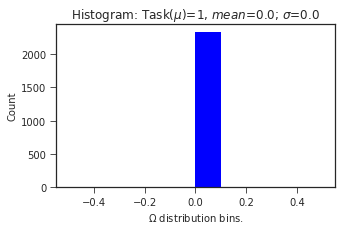

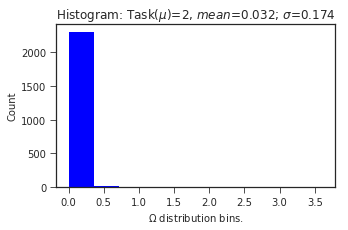

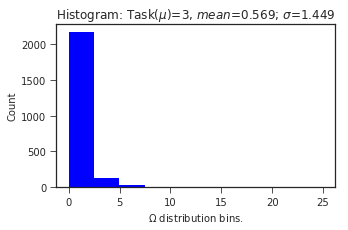

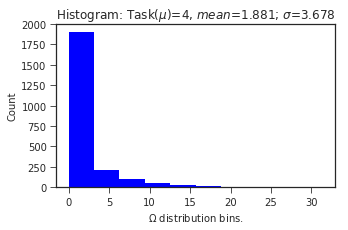

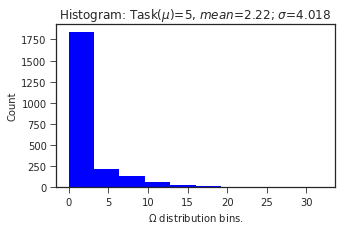

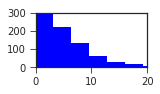

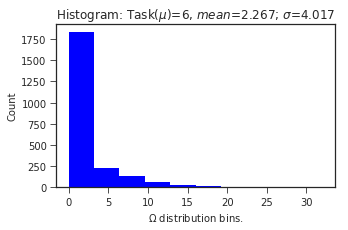

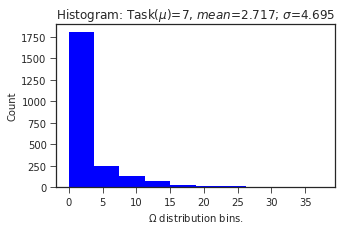

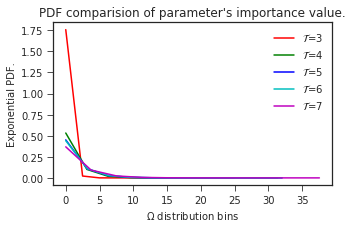

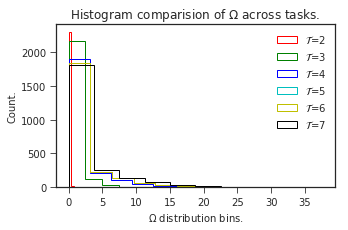

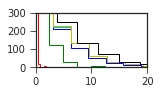

In [71]:
# histogram plot
from numpy.random import seed
from numpy.random import randn
#%matplotlib inline
from matplotlib import pyplot as plt
import itertools
import pdb

def flatten(x):
    try:
        it = iter(x)
    except TypeError:
        yield x
    else:
        for i in it:
            for j in flatten(i):
                yield j
                
per_task_big_omega_dump = []
for i,epoch_id in enumerate(last_epoch_batchindex):
    key = list(history.big_omega[epoch_id].keys())
    per_task_big_omega_dump.append(list(flatten([history.big_omega[epoch_id][ke] for ke in key])))

pdf_save = []
bins_edge_save = []
import scipy
for i in range(len(per_task_big_omega_dump)):
    plt.figure(figsize=(5,3))
    ax = subplot(1,1,1)
    _, bins, _ = ax.hist(per_task_big_omega_dump[i], 10, density=0, color='blue')
    mu, sigma = scipy.stats.expon.fit(per_task_big_omega_dump[i])
    best_fit_line = scipy.stats.expon.pdf(bins, mu, sigma)
    ax.set_ylabel('Count')
    ax.set_xlabel('$\Omega$ distribution bins.')
    #ax.yaxis.label.set_color('blue')
    #second_ax = ax.twinx()
    #second_ax.plot(bins, best_fit_line, color='red')
    pdf_save.append(best_fit_line)
    bins_edge_save.append(bins)
    #second_ax.set_ylabel('Exponential PDF.', color='red')
    ax.set_title('Histogram: Task($\mu$)='+str(i+1)+ ', $mean$='+str(round(np.mean(per_task_big_omega_dump[i]),3))+'; $\sigma$='+str(round(np.std(per_task_big_omega_dump[i]),3)))
    if i==4 :
        plt.savefig('SIOmega_dist_UNSW.pdf', bbox_inches = "tight") 
        plt.figure(figsize=(2,1))
        axs = subplot(1,1,1)
        _, bins, _ = axs.hist(per_task_big_omega_dump[i], bins=10, density=0, color='blue')
        axs.set_ylim(0,300)
        axs.set_xlim(0,20)
        axs.set_xticks([0, 10, 20])
        axs.set_yticks([0,100, 200, 300])
        plt.savefig('SIOmega_Zoom_dist_UNSW.pdf', bbox_inches = "tight")
        import pickle
        with open('UNSW_T5_SI_Omega.pkl', 'wb') as f:
            pickle.dump(per_task_big_omega_dump[i], f)
plt.figure(figsize=(5,3))
axs = subplot(1,1,1)
colorVal = ['r','g','b','c','m','k','y','tomato']
marker=["v","^","<",">","*","s","h","x","."]

for j,i in enumerate(range(2,len(per_task_big_omega_dump))):  
    axs.plot(bins_edge_save[i], pdf_save[i], color=colorVal[j], label="$\mathcal{T}$=%g"%(i+1))
axs.set_ylabel('Exponential PDF.')
axs.set_xlabel('$\Omega$ distribution bins')
axs.set_title("PDF comparision of parameter\'s importance value.")
axs.legend()

plt.figure(figsize=(5,3))
axs = subplot(1,1,1)
colorVal = ['r','g','b','c','y','k','m','tomato']
marker=["v","^","<",">","*","s","h","x","."]
for j,i in enumerate(range(1,len(per_task_big_omega_dump))):  
    _, bins, _ = axs.hist(per_task_big_omega_dump[i], bins=10, density=0, color=colorVal[j], linewidth=1, histtype=u'step', label="$\mathcal{T}$=%g"%(i+1))
axs.set_ylabel('Count.')
axs.set_xlabel('$\Omega$ distribution bins.')
axs.set_title("Histogram comparision of $\Omega$ across tasks.")
axs.legend()
plt.savefig('SIHist_comparision_UNSW.pdf', bbox_inches = "tight") 

plt.figure(figsize=(2,1))
axs = subplot(1,1,1)
colorVal = ['r','g','b','c','y','k','m','tomato']
marker=["v","^","<",">","*","s","h","x","."]
for j,i in enumerate(range(1,len(per_task_big_omega_dump))):  
    _, bins, _ = axs.hist(per_task_big_omega_dump[i], bins=10, density=0, color=colorVal[j], linewidth=1, histtype=u'step', label="$\mathcal{T}$=%g"%(i+1))
axs.set_ylim(0,300)
axs.set_xlim(0,20)
axs.set_xticks([0, 10, 20])
axs.set_yticks([0,100, 200, 300])
plt.savefig('SIHist_comparision_Zoom_UNSW.pdf', bbox_inches = "tight") 

0.0 32.02322
0.0 0.27617430746089666
0.0 4.7821164
-----SI------------
Bin edge   ::  Frequency
---------------------
0.0       ::      1838
3.202322       ::      222
6.404644       ::      134
9.606966       ::      65
12.809288       ::      30
16.01161       ::      20
19.213932       ::      9
22.416254       ::      6
25.618576       ::      4
28.820898       ::      4
-----EWC------------
Bin edge   ::  Frequency
---------------------
0.0       ::      2201
0.027617430746089668       ::      67
0.055234861492179335       ::      35
0.08285229223826901       ::      17
0.11046972298435867       ::      5
0.13808715373044833       ::      3
0.16570458447653802       ::      3
0.19332201522262768       ::      0
0.22093944596871734       ::      0
0.248556876714807       ::      1
-----FSI------------
Bin edge   ::  Frequency
---------------------
0.0       ::      2097
0.47821164       ::      118
0.9564233       ::      48
1.4346349       ::      23
1.9128466       ::      14
2.3

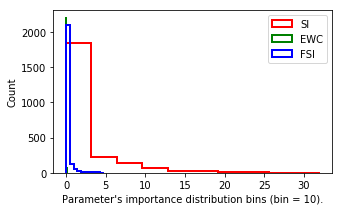

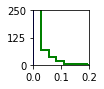

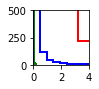

In [2]:
#Comparing histogram across algos for task 5
import pickle
import csv
open_file = open('UNSW_T5_SI_Omega.pkl', "rb")
SI_task = pickle.load(open_file)
print(min(SI_task), max(SI_task))
open_file.close()
with open('UNSW_T5_SI_Omega.csv', 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=0)
     wr.writerow(SI_task)
myfile.close()

open_file = open('/root/Elastic-Weight-Consolidation-task-continual/UNSW-EWC/UNSW_T5_EWC_Omega.pkl', "rb")
EWC_task = pickle.load(open_file)
print(min(EWC_task), max(EWC_task))
open_file.close()
with open('UNSW_T5_EWC_Fisher.csv', 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=0)
     wr.writerow(EWC_task)
myfile.close()

open_file = open('/root/pathint-Fisher/fig_split_mnist/UNSW_T5_FSI_Omega.pkl', "rb")
FSI_task = pickle.load(open_file)
print(min(FSI_task), max(FSI_task))
open_file.close()
with open('UNSW_T5_FSI_Fisher.csv', 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=0)
     wr.writerow(FSI_task)
myfile.close()

import matplotlib.pyplot as plt
from matplotlib.pyplot import subplot
import numpy as np
plt.figure(figsize=(5,3))
axs = subplot(1,1,1)
bins = 10 #np.linspace(0, 1, 20)
axs.hist(SI_task, bins=bins, density=0, color='red', linewidth=2, histtype=u'step', label='SI')
axs.hist(EWC_task, bins=bins, density=0, color='green', linewidth=2, histtype=u'step', label='EWC')
axs.hist(FSI_task, bins=bins, density=0, color='blue', linewidth=2, histtype=u'step', label='FSI')
axs.legend()
axs.set_ylabel('Count')
axs.set_xlabel('Parameter\'s importance distribution bins (bin = 10).')
plt.savefig('Hist_comparision_All_T5.pdf', bbox_inches = "tight") 

plt.figure(figsize=(1,1))
axs = subplot(1,1,1)
axs.hist(SI_task, bins=bins, density=0, color='red', linewidth=2, histtype=u'step', label='SI')
axs.hist(EWC_task, bins=bins, density=0, color='green', linewidth=2, histtype=u'step', label='EWC')
axs.hist(FSI_task, bins=bins, density=0, color='blue', linewidth=2, histtype=u'step', label='FSI')
axs.set_ylim(0,250)
axs.set_xlim(0,0.2)
axs.set_xticks([0, 0.1, 0.2])
axs.set_yticks([0, 125, 250])
plt.savefig('Hist_Zoom_comparision_All_T5.pdf', bbox_inches = "tight") 

plt.figure(figsize=(1,1))
axs = subplot(1,1,1)
axs.hist(SI_task, bins=bins, density=0, color='red', linewidth=2, histtype=u'step', label='SI')
axs.hist(EWC_task, bins=bins, density=0, color='green', linewidth=2, histtype=u'step', label='EWC')
axs.hist(FSI_task, bins=bins, density=0, color='blue', linewidth=2, histtype=u'step', label='FSI')
axs.set_ylim(0, 500)
axs.set_xlim(0,4)
axs.set_xticks([0, 2, 4])
axs.set_yticks([0, 250, 500])
plt.savefig('Hist_Zoom2_comparision_All_T5.pdf', bbox_inches = "tight") 

SI_hist,SI_bin_edges = np.histogram(SI_task, bins=10)
EWC_hist,EWC_bin_edges = np.histogram(EWC_task, bins=10)
FSI_hist,FSI_bin_edges = np.histogram(FSI_task, bins=10)
SI_dictionary = dict(zip(SI_bin_edges, SI_hist))
EWC_dictionary = dict(zip(EWC_bin_edges, EWC_hist))
FSI_dictionary = dict(zip(FSI_bin_edges, FSI_hist))
print('-----SI------------')
print('Bin edge   ::  Frequency')
print('---------------------')
for key in sorted(SI_dictionary.keys()) :
    print(key , "      ::     " , SI_dictionary[key])
    
print('-----EWC------------')
print('Bin edge   ::  Frequency')
print('---------------------')
for key in sorted(EWC_dictionary.keys()) :
    print(key , "      ::     " , EWC_dictionary[key])
    
print('-----FSI------------')
print('Bin edge   ::  Frequency')
print('---------------------')
for key in sorted(FSI_dictionary.keys()) :
    print(key , "      ::     " , FSI_dictionary[key])
    
SI_dictionary = [{'bins_edge': i, 'frequency':j} for i,j in zip(SI_bin_edges, SI_hist)]   
EWC_dictionary = [{'bins_edge': i, 'frequency':j} for i,j in zip(EWC_bin_edges, EWC_hist)]   
FSI_dictionary = [{'bins_edge': i, 'frequency':j} for i,j in zip(FSI_bin_edges, FSI_hist)]   
print(SI_dictionary)

with open('UNSW_T5_SI_Omega_hist.csv', 'w', newline='') as myfile:
     wr = csv.DictWriter(myfile, quoting=0, fieldnames=['bins_edge', 'frequency'])
     wr.writeheader()
     wr.writerows(SI_dictionary)
myfile.close()

with open('UNSW_T5_EWC_Fisher_hist.csv', 'w', newline='') as myfile:
     wr = csv.DictWriter(myfile, quoting=0, fieldnames=['bins_edge', 'frequency'])
     wr.writeheader()
     wr.writerows(EWC_dictionary)
myfile.close()

with open('UNSW_T5_FSI_Fisher_hist.csv', 'w', newline='') as myfile:
     wr = csv.DictWriter(myfile, quoting=0, fieldnames=['bins_edge', 'frequency'])
     wr.writeheader()
     wr.writerows(FSI_dictionary)
myfile.close()


In [89]:
EWC_hist,EWC_bin_edges = np.histogram(EWC_task, bins=10)
other_bins = np.append(EWC_bin_edges, np.array(2* EWC_bin_edges[-1]))
other_bins = np.append(other_bins, np.array(4* EWC_bin_edges[-1]))
other_bins = np.append(other_bins, np.array(8* EWC_bin_edges[-1]))
FSI_hist,FSI_bin_edges = np.histogram(FSI_task, bins=other_bins)
SI_hist,SI_bin_edges = np.histogram(SI_task, bins=other_bins)

SI_dictionary = dict(zip(SI_bin_edges, SI_hist))
EWC_dictionary = dict(zip(EWC_bin_edges, EWC_hist))
FSI_dictionary = dict(zip(FSI_bin_edges, FSI_hist))

SI_dictionary[sorted(SI_dictionary.keys())[-1]]  =sum(i > sorted(SI_dictionary.keys())[-2] for i in SI_task)
FSI_dictionary[sorted(FSI_dictionary.keys())[-1]]  =sum(i > sorted(FSI_dictionary.keys())[-2] for i in FSI_task)
SI_hist[-1] = SI_dictionary[sorted(SI_dictionary.keys())[-1]]
FSI_hist[-1] = FSI_dictionary[sorted(FSI_dictionary.keys())[-1]]
print('-----EWC------------')
print('Bin edge   ::  Frequency')
print('---------------------')
for key in sorted(EWC_dictionary.keys()) :
    print(key , "      ::     " , EWC_dictionary[key])

print('-----SI------------')
print('Bin edge   ::  Frequency')
print('---------------------')
for key in sorted(SI_dictionary.keys()) :
    print(key , "      ::     " , SI_dictionary[key])
    
print('-----FSI------------')
print('Bin edge   ::  Frequency')
print('---------------------')
for key in sorted(FSI_dictionary.keys()) :
    print(key , "      ::     " , FSI_dictionary[key])
    
SI_dictionary = [{'bins_edge': i, 'frequency':j} for i,j in zip(SI_bin_edges, SI_hist)]   
EWC_dictionary = [{'bins_edge': i, 'frequency':j} for i,j in zip(EWC_bin_edges, EWC_hist)]   
FSI_dictionary = [{'bins_edge': i, 'frequency':j} for i,j in zip(FSI_bin_edges, FSI_hist)]   

with open('UNSW_T5_SI_Omega_hist.csv', 'w', newline='') as myfile:
     wr = csv.DictWriter(myfile, quoting=0, fieldnames=['bins_edge', 'frequency'])
     wr.writeheader()
     wr.writerows(SI_dictionary)
myfile.close()

with open('UNSW_T5_EWC_Fisher_hist.csv', 'w', newline='') as myfile:
     wr = csv.DictWriter(myfile, quoting=0, fieldnames=['bins_edge', 'frequency'])
     wr.writeheader()
     wr.writerows(EWC_dictionary)
myfile.close()

with open('UNSW_T5_FSI_Fisher_hist.csv', 'w', newline='') as myfile:
     wr = csv.DictWriter(myfile, quoting=0, fieldnames=['bins_edge', 'frequency'])
     wr.writeheader()
     wr.writerows(FSI_dictionary)
myfile.close()

-----EWC------------
Bin edge   ::  Frequency
---------------------
0.0       ::      2201
0.027617430746089668       ::      67
0.055234861492179335       ::      35
0.08285229223826901       ::      17
0.11046972298435867       ::      5
0.13808715373044833       ::      3
0.16570458447653802       ::      3
0.19332201522262768       ::      0
0.22093944596871734       ::      0
0.248556876714807       ::      1
-----SI------------
Bin edge   ::  Frequency
---------------------
0.0       ::      311
0.027617430746089668       ::      137
0.055234861492179335       ::      131
0.08285229223826901       ::      127
0.11046972298435867       ::      117
0.13808715373044833       ::      96
0.16570458447653802       ::      53
0.19332201522262768       ::      52
0.22093944596871734       ::      34
0.248556876714807       ::      26
0.27617430746089666       ::      161
0.5523486149217933       ::      225
1.1046972298435866       ::      1087
-----FSI------------
Bin edge   ::  Frequen

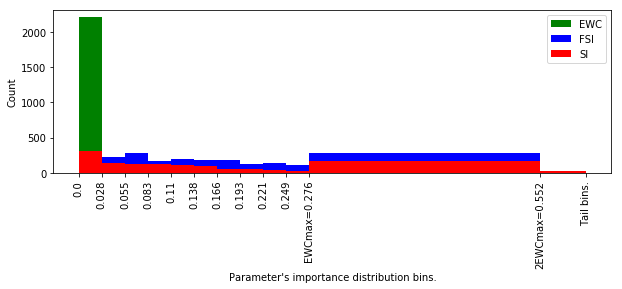

<Figure size 432x288 with 0 Axes>

In [53]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplot
import numpy as np
plt.figure(figsize=(10,3))
axs = subplot(1,1,1)
bins = 10 #np.linspace(0, 1, 20)
_, bins, _ = axs.hist(EWC_task, bins=bins, density=0, color='green', linewidth=2,  label='EWC')
#axs2.hist(FSI_task, bins=10, density=0, color='blue', linewidth=2, histtype=u'step', label='FSI')
#axs3.hist(SI_task, bins=10, density=0, color='red', linewidth=2, histtype=u'step', label='SI')
axs.set_ylabel('Count')
axs.set_xlabel('Parameter\'s importance distribution bins.')
Bins = list(bins)
Bins.append(2*bins[-1])
Bins.append(2.2*bins[-1])
axs.set_xticks(Bins)
Bin_label = [round(i,3) for i in Bins]
Bin_label[-3] = 'EWCmax='+str(Bin_label[-3])
Bin_label[-2] = '2EWCmax='+str(round(Bins[-2],3))
Bin_label[-1] = 'Tail bins.'
axs.set_xticklabels(Bin_label, Rotation='vertical' ) 
axs.hist(FSI_task, bins=Bins, density=0, color='blue', linewidth=2,  label='FSI')
axs.hist(SI_task, bins=Bins, density=0, color='red', linewidth=2, label='SI')
axs.legend()
plt.show()
plt.savefig('Hist_comparision_All_T5.pdf', bbox_inches = "tight") 

In [12]:
#Inspection of losses after every task 
loss_after_task=[]
print('Batch-id for last epoch of each task:',last_epoch_batchindex)
print('*----------------------------*')
for i,epoch_id in enumerate(last_epoch_batchindex):
    loss_after_task.append(history.losses[epoch_id])
    print('Loss after task {0} '.format(i), history.losses[epoch_id]) 
print('*----------------------------*')

#Inspection of surrogate loss or regularization (sum(big_omega x (theta'-theta))) after every task 
surrogate_loss_after_task=[]
for i,epoch_id in enumerate(last_epoch_batchindex):
    surrogate_loss_after_task.append(history.regs[epoch_id])
    print('Surrogate loss after task {0} '.format(i), history.regs[epoch_id]) 

Batch-id for last epoch of each task: [69, 6399, 10299, 12679, 12879, 13889, 14639]
*----------------------------*
Loss after task 0  0.27614665
Loss after task 1  0.022680625
Loss after task 2  0.22924286
Loss after task 3  0.50259393
Loss after task 4  0.6762841
Loss after task 5  0.10689821
Loss after task 6  0.4072529
*----------------------------*
Surrogate loss after task 0  0.0
Surrogate loss after task 1  0.00046743313
Surrogate loss after task 2  0.014614787
Surrogate loss after task 3  0.0009873752
Surrogate loss after task 4  0.0010190796
Surrogate loss after task 5  0.008887434
Surrogate loss after task 6  0.10613201


In [13]:
import h5py
print(model.summary())
model.save_weights('saved_weights.h5') #This file cannot be opend normaly to view the weghts. It can be loaded through load_model() or can be opend via hdf5 viewer

#Shape of the array containg model weights
a_list = model.get_weights()
for i in range(len(a_list)):
    print((np.array(a_list[i])).shape)

#a_list[0][0][0] = a_list[0][0][0]+0.00001
#print(a_list[0][0][0])
#model.set_weights(a_list)

#from keras.utils.vis_utils import plot_model
#import pydot
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 43)                1892      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                440       
Total params: 2,332
Trainable params: 2,332
Non-trainable params: 0
_________________________________________________________________
None
(43, 43)
(43,)
(43, 10)
(10,)


In [14]:
data = utils.load_zipped_pickle(datafile_name)
print(cvals)

[1.0]


In [15]:
'''
print(data['mean'])
for k in cvals:
    for i in range(n_tasks):
        for j in range(i):
            data['mean'][k][j][i] = 0
            data['std'][k][j][i] = 0
'''

"\nprint(data['mean'])\nfor k in cvals:\n    for i in range(n_tasks):\n        for j in range(i):\n            data['mean'][k][j][i] = 0\n            data['std'][k][j][i] = 0\n"

In [16]:
import matplotlib.colors as colors
cmap = plt.get_cmap('cool') 
cNorm  = colors.Normalize(vmin=-5, vmax=np.log(np.max(list(data['mean'].keys()))))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
print(scalarMap.get_clim())

(-5.0, 0.0)


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


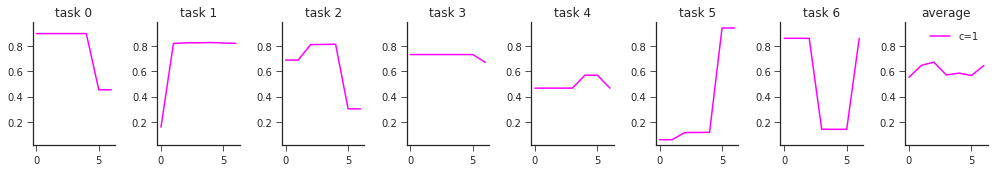

In [17]:
figure(figsize=(14, 2.5))
axs = [subplot(1,n_tasks+1,1)]#, None, None]
for i in range(1, n_tasks + 1):
    axs.append(subplot(1, n_tasks+1, i+1, sharex=axs[0], sharey=axs[0]))
    
keys = list(data['mean'].keys())
sorted_keys = np.sort(keys)

for cval in sorted_keys:
    mean_vals = data['mean'][cval]
    std_vals = data['std'][cval]
    for j in range(n_tasks):
        colorVal = scalarMap.to_rgba(np.log(cval))
        # axs[j].plot(evals[:, j], c=colorVal)
        axs[j].errorbar(range(n_tasks), mean_vals[:, j], yerr=std_vals[:, j]/np.sqrt(n_stats), c=colorVal)
    label = "c=%g"%cval
    average = mean_vals.mean(1)  #Taking the average of cross validation accuracies accross all tasks after learning each task
    axs[-1].plot(average, c=colorVal, label=label)
    
for i, ax in enumerate(axs):
    ax.legend(loc='best')
    ax.set_title((['task %d'%j for j in range(n_tasks)] + ['average'])[i])
gcf().tight_layout()
sns.despine()
plt.savefig('2Attack_Accuracy_10task.pdf')

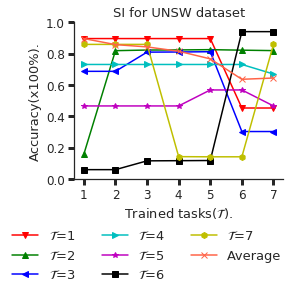

In [18]:
import pdb
figure(figsize=(4, 4.5))
axs = [subplot(1,1,1)]#, None, None]
fontsize = 13

keys = list(data['mean'].keys())
sorted_keys = np.sort(keys)

colorVal = ['r','g','b','c','m','k','y','tomato']
marker=["v","^","<",">","*","s","h","x","."]

mean_stuff=[]
std_stuff=[]
for i in range(len(data['mean'][cval])):
    mean_stuff.append(data['mean'][cval][i][:i+1].mean())
    std_stuff.append(np.sqrt((data['std'][cval][i][:i+1]**2).sum())/(n_stats*np.sqrt(n_stats)))

for cval in sorted_keys:
    mean_vals = data['mean'][cval]
    std_vals = data['std'][cval]
    for j in range(n_tasks):
        label = "$\mathcal{T}$=%g"%(j+1)
        axs[0].plot(range(1,n_tasks+1), mean_vals[:, j], marker=marker[j], c=colorVal[j], label=label)
    axs[0].plot(range(1,n_tasks+1), mean_stuff, marker=marker[j+1], c=colorVal[j+1], label='Average')
    axs[0].legend(loc='upper right',prop={'size': fontsize}, bbox_to_anchor=(1.05, -0.25), ncol=3)
    axs[0].set_xlabel("Trained tasks($\mathcal{T}$).",fontsize=fontsize)
    axs[0].set_ylabel('Accuracy(x100%).',fontsize=fontsize)
    axs[0].set_xticks(range(1,n_tasks+1))
    axs[0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    axs[0].tick_params(labelsize='large', width=3)
    axs[0].set_title('SI for UNSW dataset', fontsize=fontsize)
#plt.legend(bbox_to_anchor=(0.78, 0.66),bbox_transform=plt.gcf().transFigure)
gcf().tight_layout()
sns.despine()
plt.savefig('UNSW_SI_congestion.pdf',bbox_inches = "tight")

In [21]:
data['mean'][cval], mean_stuff

(array([[0.89707047, 0.15778075, 0.68747422, 0.7313884 , 0.46609717,
         0.058653  , 0.85978688],
        [0.89707047, 0.81999068, 0.68747422, 0.7313884 , 0.46609717,
         0.058653  , 0.85978688],
        [0.89707047, 0.84218917, 0.24193936, 0.7313884 , 0.46609717,
         0.05911891, 0.85978688],
        [0.89707047, 0.84218917, 0.23865668, 0.73154171, 0.46609717,
         0.05911891, 0.14147504],
        [0.89707047, 0.84218917, 0.23805514, 0.73154171, 0.54004271,
         0.05911891, 0.14301739],
        [0.45288994, 0.84221925, 0.30343393, 0.73154171, 0.54057662,
         0.941347  , 0.1431576 ],
        [0.45288994, 0.84221925, 0.30343393, 0.63449197, 0.46609717,
         0.941347  , 0.85978688]]),
 [0.897070467141726,
  0.8585305712857417,
  0.6603996667914788,
  0.6773645060461635,
  0.6497798392937553,
  0.6353347423898033,
  0.6428951635990503])

/usr/local/lib/python3.5/dist-packages/matplotlib/legend.py:493: UserWarning: Unrecognized location "top". Falling back on "best"; valid locations are
	center right
	upper center
	lower center
	lower right
	best
	upper right
	center
	right
	center left
	lower left
	upper left

  % (loc, '\n\t'.join(self.codes)))


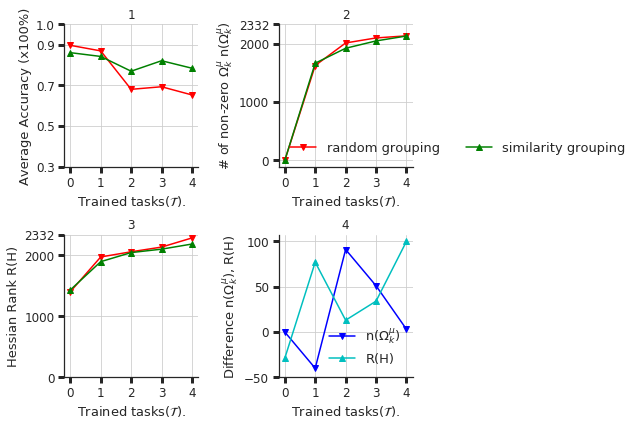

In [130]:
#Only for task grouping 
ungrouped_acc = [0.897070467141726,
 0.8696448574297311,
 0.6806443510780911,
 0.6932865574365223,
 0.6529741471771944] 
grouped_acc = [0.8610328638497653,
 0.8423751646208442,
 0.7697378105864172,
 0.821235631732382,
 0.7844140805974705]

Ungrouped_big_omega = [0, 1627, 2014,2100,2136]
grouped_big_omega = [0, 1667, 1923,2049,2133]
Ungrouped_rank = [1402, 1972, 2057, 2134, 2284]
grouped_rank = [1431, 1895, 2044, 2100, 2184]

diff_omega = [i-j for i,j in zip(Ungrouped_big_omega,grouped_big_omega)]
diff_rank = [i-j for i,j in zip(Ungrouped_rank,grouped_rank)]

figure(figsize=(8, 6))
axs = [subplot(2,2,1)]#, None, None]
for i in range(1, 4):
    axs.append(subplot(2, 2, i+1, sharex=axs[0]))
fontsize = 13

colorVal = ['r','g','b','c','m','k','y']
marker=["v","^","<",">","*","s"]

plots = [[ungrouped_acc,grouped_acc],[Ungrouped_big_omega,grouped_big_omega],[Ungrouped_rank,grouped_rank],
         [diff_omega,diff_rank]]
ylabel = ['Average Accuracy (x100%)', '# of non-zero $\Omega_k^\mu$ n($\Omega_k^\mu$)', 'Hessian Rank R(H)',
          'Difference n($\Omega_k^\mu$), R(H)']
ytick = [[0.3, 0.5, 0.7, 0.9, 1], [0, 1000, 2000, 2332], [0, 1000, 2000, 2332],[-50, 0, 50, 100]]
for i in range(3):
    axs[i].plot(range(n_tasks), plots[i][0], marker=marker[0], c=colorVal[0], label='random grouping')
    axs[i].plot(range(n_tasks), plots[i][1], marker=marker[1], c=colorVal[1], label='similarity grouping')
    axs[i].set_ylabel(ylabel[i],fontsize=fontsize)
    axs[i].set_yticks(ytick[i])
    axs[i].tick_params(labelsize='large', width=3)
    axs[i].set_xticks(range(n_tasks))
    axs[i].set_xlabel("Trained tasks($\mathcal{T}$).",fontsize=fontsize)
    axs[i].grid()
    axs[i].set_title(str(i+1))
#axs[1].legend(loc='upper right',prop={'size': fontsize}, bbox_to_anchor=(1.5, -0.25), ncol=2)    
axs[1].legend(loc='best',prop={'size': fontsize}, ncol=2)    

axs[3].plot(range(n_tasks), plots[3][0], marker=marker[0], c=colorVal[2], label='n($\Omega_k^\mu$)')
axs[3].plot(range(n_tasks), plots[3][1], marker=marker[1], c=colorVal[3], label='R(H)')
axs[3].set_ylabel(ylabel[3],fontsize=fontsize)
axs[3].set_yticks(ytick[3])
axs[3].tick_params(labelsize='large', width=3)
axs[3].set_xticks(range(n_tasks))
axs[3].set_xlabel("Trained tasks($\mathcal{T}$).",fontsize=fontsize)
axs[3].legend(loc='top',prop={'size': fontsize}, ncol=1) 
axs[3].grid()
axs[3].set_title(str(4))
    
plt.tight_layout()
sns.despine()
plt.savefig('UNSW_SI_labels_grouping.pdf',bbox_inches = "tight")

In [23]:
Flatten_weights=[]
#Flattening the weights into a list
def flatten(x):
    try:
        it = iter(x)
    except TypeError:
        yield x
    else:
        for i in it:
            for j in flatten(i):
                yield j
                
for i in range(len(model_weights_save)):
    if i == 0:
        Flatten_weights.append(list(flatten(save_weights_epoch[epochs_per_task-2])))
        Flatten_weights.append(list(flatten(save_weights_epoch[epochs_per_task-1])))
    Flatten_weights.append(list(flatten(model_weights_save[i]))) 

Extract_model_params = []
for i in range(len(Flatten_weights)):   
    Extract_model_params.append(Flatten_weights[i])
    
gradient_save=[]
for i in range(1,len(Extract_model_params)):
    if i == 2:
        pass
    else :
        temp=list(np.asarray(Extract_model_params[i])-np.asarray(Extract_model_params[i-1]))
        gradient = [j/0.001 for j in temp]
        gradient_save.append(gradient)
    
#Creating the Hessian matrix from the gradients
import math
Hessian_matrix = []
Hessian_row = []
Rank_Hessian_matrix = []
for k in range(len(gradient_save)):
    for i in range(len(gradient_save[k])):
        partial_deriv_1 = (math.ceil(gradient_save[k][i]*1e10)/1e10)
        for j in range(len(gradient_save[k])):
            partial_deriv_2 = (math.ceil(gradient_save[k][j]*1e10)/1e10)
            Hessian_row.append(np.around(partial_deriv_1*partial_deriv_2))
        Hessian_matrix.append(Hessian_row)
        Hessian_row = []
    rank_Hessian_matrix = np.linalg.matrix_rank(np.asarray(Hessian_matrix))
    Rank_Hessian_matrix.append(rank_Hessian_matrix)
    print('Rank of the Hessian Matrix after task=',k,'is :',rank_Hessian_matrix)

Rank of the Hessian Matrix after task= 0 is : 1117
Rank of the Hessian Matrix after task= 1 is : 2012
Rank of the Hessian Matrix after task= 2 is : 2100
Rank of the Hessian Matrix after task= 3 is : 2183
Rank of the Hessian Matrix after task= 4 is : 2230
Rank of the Hessian Matrix after task= 5 is : 2274
Rank of the Hessian Matrix after task= 6 is : 2320


/usr/local/lib/python3.5/dist-packages/matplotlib/tight_layout.py:330: UserWarning: tight_layout not applied: number of rows in subplot specifications mustbe multiples of one another.
  warnings.warn('tight_layout not applied: '


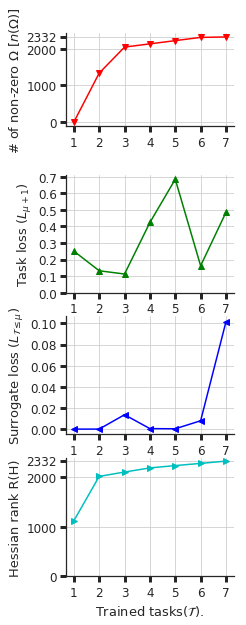

In [32]:
import pdb
figure(figsize=(3, 10))
axs = [subplot(5,1,1)]#, None, None]
for i in range(1, 4):
    axs.append(subplot(4, 1, i+1, sharex=axs[0]))
fontsize = 13

colorVal = ['r','g','b','c','m','k','y']
marker=["v","^","<",">","*","s"]

plots = [non_zero_imp_param,loss_after_task,surrogate_loss_after_task,Rank_Hessian_matrix]
ylabel = ['# of non-zero $\Omega$ $[n(\Omega)]$', 'Task loss ($L_{\mu+1}$)', 'Surrogate loss ($L_{\mathcal{T} \leq \mu}$)','Hessian rank R(H)']
ytick = [[0, 1000, 2000, 2332], [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7],[0, 0.02, 0.04, 0.06, 0.08, 0.1], [0, 1000, 2000, 2332]]
title = ['Number of non-zero importance.', 'Loss', 'Surrogate loss', 'Hessian rank']
for i in range(4):
    axs[i].plot(range(1,n_tasks+1), plots[i], marker=marker[i], c=colorVal[i])
    axs[i].set_ylabel(ylabel[i],fontsize=fontsize)
    axs[i].set_yticks(ytick[i])
    axs[i].tick_params(labelsize='large', width=3)
    axs[i].grid()
axs[-1].set_xticks(range(1,n_tasks+1))
axs[-1].set_xlabel("Trained tasks($\mathcal{T}$).",fontsize=fontsize)
plt.tight_layout()
sns.despine()
plt.savefig('UNSW_SI_evalcongestion.pdf',bbox_inches = "tight")

--------------Euclidean distance--------------------
Between task 0 and 1 : 21.09431613180776
Between task 1 and 2 : 6.723066154548912
Between task 2 and 3 : 1.335912440223947
Between task 3 and 4 : 0.5441280965196373
Between task 4 and 5 : 2.6691666940922705
Between task 5 and 6 : 0.6637632950707371
--------------Cosine distance--------------------
Between task 0 and 1 : 0.297
Between task 1 and 2 : 0.955
Between task 2 and 3 : 0.998
Between task 3 and 4 : 1.0
Between task 4 and 5 : 0.993
Between task 5 and 6 : 1.0
--------------Jaccard similarity--------------------
Between task 0 and 1 : 0.016560509554140127
Between task 1 and 2 : 0.04922149673530889
Between task 2 and 3 : 0.06977886977886978
Between task 3 and 4 : 0.12434847356664185
Between task 4 and 5 : 0.09275430729289591
Between task 5 and 6 : 0.09018318459370596
--------------Sequence Matcher--------------------
Between task 0 and 1 : 0.1072041166380789
Between task 1 and 2 : 0.1676672384219554


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  # This is added back by InteractiveShellApp.init_path()


Between task 2 and 3 : 0.16852487135506003
Between task 3 and 4 : 0.22469982847341338
Between task 4 and 5 : 0.1732418524871355
Between task 5 and 6 : 0.16938250428816468


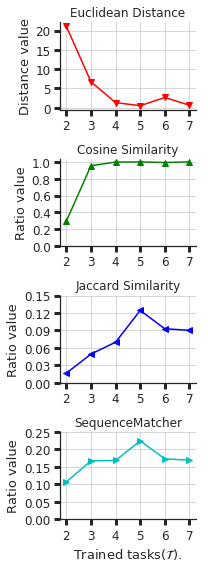

In [31]:
#Heuristic metric: Weights Pattern after training each task
from math import*
#1. Euclidean distance
def euclidean_distance(x,y):
    return sqrt(sum(pow(a-b,2) for a, b in zip(x, y)))

#2. Cosine Similarity
def square_rooted(x):
    return round(sqrt(sum([a*a for a in x])),3)
def cosine_similarity(x,y):
    numerator = sum(a*b for a,b in zip(x,y))
    denominator = square_rooted(x)*square_rooted(y)
    return round(numerator/float(denominator),3)

#3. Jaccard similarity
def jaccard_similarity(x,y):
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    return intersection_cardinality/float(union_cardinality)

#4. Using SequenceMatcher    
from difflib import SequenceMatcher

print("--------------Euclidean distance--------------------")
Eu_distance = []
for i in range(1,n_tasks):
    eu_dist = euclidean_distance(list(flatten(model_weights_save[i-1])),list(flatten(model_weights_save[i])))
    Eu_distance.append(eu_dist)
    print("Between task {0} and {1} : {2}".format(i-1,i,eu_dist))

print("--------------Cosine distance--------------------")
Cos_distance = []
for i in range(1,n_tasks):
    cos_dist = cosine_similarity(list(flatten(model_weights_save[i-1])),list(flatten(model_weights_save[i])))
    Cos_distance.append(cos_dist)
    print("Between task {0} and {1} : {2}".format(i-1,i,cos_dist))
    
    
print("--------------Jaccard similarity--------------------")
Jac_distance = []
for i in range(1,n_tasks):
    jac_dist = jaccard_similarity(list(flatten(model_weights_save[i-1])),list(flatten(model_weights_save[i])))
    Jac_distance.append(jac_dist)
    print("Between task {0} and {1} : {2}".format(i-1,i,jac_dist))

print("--------------Sequence Matcher--------------------")
Seq_matcher = []
for i in range(1,n_tasks):
    seq_matcher = SequenceMatcher(None,list(flatten(model_weights_save[i-1])),list(flatten(model_weights_save[i]))).ratio()
    Seq_matcher.append(seq_matcher)
    print("Between task {0} and {1} : {2}".format(i-1,i,seq_matcher))
    
import pdb
figure(figsize=(3, 8))
subplots_adjust(hspace=0.25,
                    wspace=0.35)
axs = [plt.subplot(4,1,1)]#, None, None]
for i in range(1, 4):
    axs.append(subplot(4, 1, i+1, sharex=axs[0]))
fontsize = 13

colorVal = ['r','g','b','c','m','k','y']
marker=["v","^","<",">","*","s"]

plots = [Eu_distance,Cos_distance,Jac_distance,Seq_matcher]
ylabel = ['Distance value', 'Ratio value', 'Ratio value','Ratio value']
ytick = [[0, 5, 10, 15, 20], [0,0.2,0.4,0.6,0.8,1],[0, 0.03, 0.06, 0.09, 0.12, 0.15], [0, 0.05, 0.1, 0.15, 0.2, 0.25]]
title = ['Euclidean Distance', 'Cosine Similarity', 'Jaccard Similarity', 'SequenceMatcher']

for i in range(4):
    axs[i].plot(range(2,n_tasks+1), plots[i], marker=marker[i], c=colorVal[i])
    axs[i].set_ylabel(ylabel[i],fontsize=fontsize)
    axs[i].set_yticks(ytick[i])
    axs[i].tick_params(labelsize='large', width=3)
    axs[i].grid()
    axs[i].set_title(title[i])
axs[-1].set_xticks(range(2,n_tasks+1))
axs[-1].set_xlabel("Trained tasks($\mathcal{T}$).",fontsize=fontsize)

plt.tight_layout()
sns.despine()
plt.savefig('UNSW_SI_Similaritymetric.pdf',bbox_inches = "tight")

In [11]:
#Heuristic metric: Weights Pattern between task 0 and last task 
from math import*
#1. Euclidean distance
def euclidean_distance(x,y):
    return sqrt(sum(pow(a-b,2) for a, b in zip(x, y)))

#2. Cosine Similarity
def square_rooted(x):
    return round(sqrt(sum([a*a for a in x])),3)
def cosine_similarity(x,y):
    numerator = sum(a*b for a,b in zip(x,y))
    denominator = square_rooted(x)*square_rooted(y)
    return round(numerator/float(denominator),3)

#3. Jaccard similarity
def jaccard_similarity(x,y):
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    return intersection_cardinality/float(union_cardinality)

#4. Using SequenceMatcher    
from difflib import SequenceMatcher


eu_dist = euclidean_distance(list(flatten(model_weights_save[0])),list(flatten(model_weights_save[-1])))
print("Euclidean distance between task {0} and {1} : {2}".format(0,len(model_weights_save)-1,eu_dist))

cos_dist = cosine_similarity(list(flatten(model_weights_save[0])),list(flatten(model_weights_save[-1])))
print("Cosine angle between task {0} and {1} : {2}".format(0,len(model_weights_save)-1,cos_dist))

jac_dist = jaccard_similarity(list(flatten(model_weights_save[0])),list(flatten(model_weights_save[-1])))
print("Jaccard similarity between task {0} and {1} : {2}".format(0,len(model_weights_save)-1,jac_dist))

seq_matcher = SequenceMatcher(None,list(flatten(model_weights_save[0])),list(flatten(model_weights_save[-1]))).ratio()
print("Sequence angle between task {0} and {1} : {2}".format(0,len(model_weights_save)-1,seq_matcher))

Euclidean distance between task 0 and 6 : 19.853671885888613
Cosine angle between task 0 and 6 : 0.336
Jaccard similarity between task 0 and 6 : 0.009402914903620122
Sequence angle between task 0 and 6 : 0.003430531732418525


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  # This is added back by InteractiveShellApp.init_path()


In [18]:
for cval in sorted_keys:
    mean_vals = data['mean'][cval]
    std_vals = data['std'][cval]
    for j in range(n_tasks):
       print(mean_vals[:, j],std_vals[:, j]/np.sqrt(n_stats))

[0.89707047 0.89707047 0.89707047 0.89707047 0.89707047 0.45288994
 0.45288994 0.45288994 0.89707047 0.89707047] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.15778075 0.84221925 0.84221925 0.84221925 0.84221925 0.84221925
 0.84221925 0.84221925 0.84221925 0.84221925] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.68747422 0.68747422 0.11800495 0.11094115 0.11088959 0.14117283
 0.14536642 0.146707   0.14607108 0.17104359] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.7313884 0.7313884 0.7313884 0.7313884 0.7313884 0.7313884 0.7313884
 0.7313884 0.7313884 0.7313884] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.46609717 0.46609717 0.46609717 0.46609717 0.56807261 0.56807261
 0.46609717 0.46609717 0.46609717 0.46609717] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.058653   0.058653   0.3274318  0.3274318  0.3274318  0.64264637
 0.6435782  0.65388    0.65362116 0.65092923] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.85978688 0.85978688 0.85978688 0.14021312 0.14021312 0.14021312
 0.85978688 0.85978688 0.85978688 0.85978688] [0. 0. 0. 0. 0. 0. 0. 0. 0.

In [19]:
plt.rc('text', usetex=False)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)

def simple_axis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()


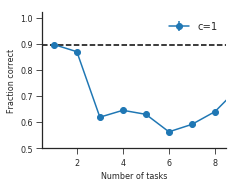

In [20]:
#Fractional Correctness = Average of cross validation accuracies of learned tasks only after training each task 
fig = plt.figure(figsize=(3.3,2.5))
ax = plt.subplot(111)

for cval in sorted_keys:
    mean_stuff = []
    std_stuff = []
    for i in range(len(data['mean'][cval])):
        mean_stuff.append(data['mean'][cval][i][:i+1].mean())
        std_stuff.append(np.sqrt((data['std'][cval][i][:i+1]**2).sum())/(n_stats*np.sqrt(n_stats)))
    # plot(range(1,n_tasks+1), mean_stuff, 'o-', label="c=%g"%cval)
    errorbar(range(1,n_tasks+1), mean_stuff, yerr=std_stuff, fmt='o-', label="c=%g"%cval)
        
axhline(data['mean'][cval][0][0], linestyle='--', color='k')
xlabel('Number of tasks')
ylabel('Fraction correct')
legend(loc='best')
xlim(0.5, 8.5)
ylim(0.5, 1.02)
# grid('on')
# sns.despine()
simple_axis(ax)
plt.savefig('2attack_fractional_correct_UNSW.pdf')

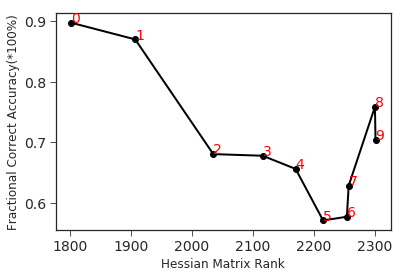

[0.897070467141726, 0.8696448574297311, 0.6806787247890768, 0.6779818040652222, 0.6562669168239876, 0.5714578153590283, 0.5774817075388184, 0.6288052173267944, 0.7585112106308061, 0.7044394974891064]


In [37]:
import matplotlib     
matplotlib.rc('xtick', labelsize=14)     
matplotlib.rc('ytick', labelsize=14)
Hess_rank=[1802, 1907, 2035, 2116, 2170, 2215, 2254, 2257, 2300, 2301] #calculated previously
plt.plot(Hess_rank,mean_stuff,'ko-', linewidth=2)
for i,j,k in zip(Hess_rank,mean_stuff,range(n_tasks)):
    plt.annotate(str(k),xy=(i,j),color='r', fontsize=14)
plt.xlabel('Hessian Matrix Rank',fontsize=12)
plt.ylabel('Fractional Correct Accuracy(*100%)',fontsize=12)
plt.savefig('Fractioncorrect-Hessian-UNSW.pdf')
plt.show()
print(mean_stuff)

In [19]:
import pandas as pd
from numpy.linalg import matrix_rank
import math
corr_matrix = []
corr_row = []
Rank_corr_matrix=[]
for j in range(n_tasks):
    df = pd.DataFrame(training_datasets[j][0])
    correlation_matrix = df.corr().values
    correlation_matrix = np.nan_to_num(correlation_matrix)
    for k in range(len(correlation_matrix)):
        for i in range(len(correlation_matrix)):
            corr_elem = (math.ceil(correlation_matrix[k][i]*1e10)/1e10)
            corr_row.append(np.around(corr_elem))
        corr_matrix.append(corr_row)
        corr_row = []
    rank_corr_matrix=np.linalg.matrix_rank(np.asarray(corr_matrix))
    Rank_corr_matrix.append(rank_corr_matrix)
    print('Rank of the Autocorrelation Matrix for task=',j,'is :',rank_corr_matrix)

Rank of the Autocorrelation Matrix for task= 0 is : 24
Rank of the Autocorrelation Matrix for task= 1 is : 36
Rank of the Autocorrelation Matrix for task= 2 is : 36
Rank of the Autocorrelation Matrix for task= 3 is : 38
Rank of the Autocorrelation Matrix for task= 4 is : 39
Rank of the Autocorrelation Matrix for task= 5 is : 39
Rank of the Autocorrelation Matrix for task= 6 is : 39
Rank of the Autocorrelation Matrix for task= 7 is : 40
Rank of the Autocorrelation Matrix for task= 8 is : 41
Rank of the Autocorrelation Matrix for task= 9 is : 41


In [23]:
#Weights Pattern after training each task
Flatten_weights=[]
#Flattening the weights into a list
def flatten(x):
    try:
        it = iter(x)
    except TypeError:
        yield x
    else:
        for i in it:
            for j in flatten(i):
                yield j
                
for i in range(len(model_weights_save)):
    Flatten_weights.append(list(flatten(model_weights_save[i]))) 

Extract_model_params = [];
#For model parameters without consolidation use val, with consolidation use val+50 
for i in range(n_tasks):   
    Extract_model_params.append(Flatten_weights[i])

In [23]:
len(save_weights_epoch),len(model_weights_save)

(0, 5)

In [52]:
#Weights Pattern after training each task
Flatten_weights=[]
#Flattening the weights into a list
def flatten(x):
    try:
        it = iter(x)
    except TypeError:
        yield x
    else:
        for i in it:
            for j in flatten(i):
                yield j
                
for i in range(len(model_weights_save)):
    if i == 0:
        Flatten_weights.append(list(flatten(save_weights_epoch[epochs_per_task-2])))
        Flatten_weights.append(list(flatten(save_weights_epoch[epochs_per_task-1])))
    Flatten_weights.append(list(flatten(model_weights_save[i]))) 

Extract_model_params = [];
#For model parameters without consolidation use val, with consolidation use val+80 
for i in range(len(Flatten_weights)):   
    Extract_model_params.append(Flatten_weights[i])
    
gradient_save=[]
for i in range(1,len(Extract_model_params)):
    if i == 2:
        pass
    else :
        temp=list(np.asarray(Extract_model_params[i])-np.asarray(Extract_model_params[i-1]))
        gradient = [j/0.001 for j in temp]
        gradient_save.append(gradient)
    
#Creating the Hessian matrix from the gradients
import math
Hessian_matrix = []
Hessian_row = []
Rank_Hessian_matrix = []
for k in range(len(gradient_save)):
    for i in range(len(gradient_save[k])):
        partial_deriv_1 = (math.ceil(gradient_save[k][i]*1e10)/1e10)
        for j in range(len(gradient_save[k])):
            partial_deriv_2 = (math.ceil(gradient_save[k][j]*1e10)/1e10)
            Hessian_row.append(np.around(partial_deriv_1*partial_deriv_2))
        Hessian_matrix.append(Hessian_row)
        Hessian_row = []
    rank_Hessian_matrix = np.linalg.matrix_rank(np.asarray(Hessian_matrix))
    Rank_Hessian_matrix.append(rank_Hessian_matrix)
    print('Rank of the Hessian Matrix after task=',k,'is :',rank_Hessian_matrix)

Rank of the Hessian Matrix after task= 0 is : 854
Rank of the Hessian Matrix after task= 1 is : 1661
Rank of the Hessian Matrix after task= 2 is : 1774
Rank of the Hessian Matrix after task= 3 is : 1948
Rank of the Hessian Matrix after task= 4 is : 1993
Rank of the Hessian Matrix after task= 5 is : 2034
Rank of the Hessian Matrix after task= 6 is : 2065
Rank of the Hessian Matrix after task= 7 is : 2085
Rank of the Hessian Matrix after task= 8 is : 2099
Rank of the Hessian Matrix after task= 9 is : 2104


In [88]:
#Weights Pattern after training each task
Flatten_weights=[]
#Flattening the weights into a list
def flatten(x):
    try:
        it = iter(x)
    except TypeError:
        yield x
    else:
        for i in it:
            for j in flatten(i):
                yield j
                
                
for i in range(n_tasks):
    Flatten_weights.append(list(flatten(save_weights_epoch[(i+1)*epochs_per_task-2])))
    Flatten_weights.append(list(flatten(save_weights_epoch[(i+1)*epochs_per_task-1])))

Extract_model_params = [];
#For model parameters without consolidation use val, with consolidation use val+80 
for i in range(len(Flatten_weights)):   
    Extract_model_params.append(Flatten_weights[i])
    
gradient_save=[]
for i in range(1,len(Extract_model_params),2):
    temp=list(np.asarray(Extract_model_params[i])-np.asarray(Extract_model_params[i-1]))
    
    gradient = [j/0.001 for j in temp]
    gradient_save.append(gradient)
    
#Creating the Hessian matrix from the gradients
import math
Hessian_matrix = []
Hessian_row = []
Rank_Hessian_matrix = []
for k in range(len(gradient_save)):
    for i in range(len(gradient_save[k])):
        partial_deriv_1 = (math.ceil(gradient_save[k][i]*1e10)/1e10)
        for j in range(len(gradient_save[k])):
            partial_deriv_2 = (math.ceil(gradient_save[k][j]*1e10)/1e10)
            Hessian_row.append(np.around(partial_deriv_1*partial_deriv_2))
        Hessian_matrix.append(Hessian_row)
        Hessian_row = []
    rank_Hessian_matrix = np.linalg.matrix_rank(np.asarray(Hessian_matrix))
    Rank_Hessian_matrix.append(rank_Hessian_matrix)
    print('Rank of the Hessian Matrix after task=',k,'is :',rank_Hessian_matrix)

Rank of the Hessian Matrix after task= 0 is : 932
Rank of the Hessian Matrix after task= 1 is : 1737
Rank of the Hessian Matrix after task= 2 is : 1800
Rank of the Hessian Matrix after task= 3 is : 1870
Rank of the Hessian Matrix after task= 4 is : 1902
Rank of the Hessian Matrix after task= 5 is : 1967
Rank of the Hessian Matrix after task= 6 is : 2071
Rank of the Hessian Matrix after task= 7 is : 2117
Rank of the Hessian Matrix after task= 8 is : 2130
Rank of the Hessian Matrix after task= 9 is : 2134


In [24]:
#Weights Pattern after training each task
from math import*
#1. Euclidean distance
def euclidean_distance(x,y):
    return sqrt(sum(pow(a-b,2) for a, b in zip(x, y)))
#2. Manhattan Distance
def manhattan_distance(x,y):
    return sum(abs(a-b) for a,b in zip(x,y))
#3.  Minkowski distance 
from decimal import Decimal
def nth_root(value, n_root):
    root_value = 1/float(n_root)
    return round (Decimal(value) ** Decimal(root_value),3)
def minkowski_distance(x,y,p_value):
    return nth_root(sum(pow(abs(a-b),p_value) for a,b in zip(x, y)),p_value)
#4. Cosine Similarity
def square_rooted(x):
    return round(sqrt(sum([a*a for a in x])),3)
def cosine_similarity(x,y):
    numerator = sum(a*b for a,b in zip(x,y))
    denominator = square_rooted(x)*square_rooted(y)
    return round(numerator/float(denominator),3)
#5. Jaccard similarity
def jaccard_similarity(x,y):
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    return intersection_cardinality/float(union_cardinality)
#6. Using Heuristic    
import difflib 

for i in [0,1,2,3,4,5,6,7,8]:
    print("Eucledian Parameter shift after task {0} :".format(i+1),euclidean_distance(Extract_model_params[i],Extract_model_params[i+1]))
for i in [0,1,2,3,4,5,6,7,8]:
    print("Cosine Parameter shift after task {0} :".format(i+1),cosine_similarity(Extract_model_params[i],Extract_model_params[i+1]))
for i in [0,1,2,3,4,5,6,7,8]:
    print("Jaccard Parameter shift after task {0} :".format(i+1),jaccard_similarity(Extract_model_params[i],Extract_model_params[i+1]))
for i in [0,1,2,3,4,5,6,7,8]:
    print("Heuristic Parameter shift after task {0} :".format(i+1),difflib.SequenceMatcher(None,Extract_model_params[i],Extract_model_params[i+1]).ratio())

Eucledian Parameter shift after task 1 : 18.42116476268859
Eucledian Parameter shift after task 2 : 9.208601450530098
Eucledian Parameter shift after task 3 : 3.934590313084037
Eucledian Parameter shift after task 4 : 0.7763082720953064
Eucledian Parameter shift after task 5 : 2.4158320680373264
Eucledian Parameter shift after task 6 : 2.6746329869635184
Eucledian Parameter shift after task 7 : 5.5886347410127915
Eucledian Parameter shift after task 8 : 3.289132188129787
Eucledian Parameter shift after task 9 : 3.2878901208808284
Cosine Parameter shift after task 1 : 0.132
Cosine Parameter shift after task 2 : 0.891
Cosine Parameter shift after task 3 : 0.981
Cosine Parameter shift after task 4 : 0.999
Cosine Parameter shift after task 5 : 0.993
Cosine Parameter shift after task 6 : 0.992
Cosine Parameter shift after task 7 : 0.966
Cosine Parameter shift after task 8 : 0.989
Cosine Parameter shift after task 9 : 0.989
Jaccard Parameter shift after task 1 : 0.16968781470292044
Jaccard P

In [44]:
#Counting the number of changed parameters
changed_model_parameters=[]
for i in range(1,len(Extract_model_params)):
    temp=[]
    for j,k in zip(Extract_model_params[i],Extract_model_params[i-1]):
        temp.append(abs(i-j))
    changed_model_parameters.append(temp)
print(len(changed_model_parameters))

import csv
#Save the model parameters in text file
with open('temp', 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(Extract_model_params)

4


In [51]:
#Number of parameters unchanged within the thresold. Checked for five threshold values as [1e-5, 1e-4, 1e-3, 1e-2, 1e-1].
for i in range(len(changed_model_parameters)):
    print('-----After learning',i+2,'task-----')
    for j in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]:
        print(j,'---->',sum(k < j for k in changed_model_parameters[i]))

-----After learning 2 task-----
1e-05 ----> 0
0.0001 ----> 0
0.001 ----> 0
0.01 ----> 1
0.1 ----> 14
-----After learning 3 task-----
1e-05 ----> 0
0.0001 ----> 0
0.001 ----> 0
0.01 ----> 0
0.1 ----> 0
-----After learning 4 task-----
1e-05 ----> 0
0.0001 ----> 0
0.001 ----> 0
0.01 ----> 0
0.1 ----> 1
-----After learning 5 task-----
1e-05 ----> 0
0.0001 ----> 0
0.001 ----> 0
0.01 ----> 0
0.1 ----> 1


In [25]:
#Saving the parameters for future use
import pickle
with open("UNSW_Parameters.txt", "wb") as fp:   #Pickling
    pickle.dump(model_weights_save, fp)
    
with open("UNSW_Parameters.txt", "rb") as fp:   # Unpickling
    b = pickle.load(fp)